In [1]:
import pandas as pd
import yfinance as yf
import yahoofinancials

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
#import pyvirtualdisplay

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

[*********************100%***********************]  1 of 1 completed
(390, 6)
2020-06-01 15:59:00-04:00
(389, 6)
                                 Open        High         Low       Close  \
Datetime                                                                    
2020-06-01 09:30:00-04:00  858.000000  863.679993  854.099976  862.750000   
2020-06-01 09:31:00-04:00  862.719971  864.679993  860.789978  863.530029   
2020-06-01 09:32:00-04:00  868.265015  868.270020  863.500000  864.645020   
2020-06-01 09:33:00-04:00  864.090027  864.570007  862.229980  863.364990   
2020-06-01 09:34:00-04:00  863.000000  865.341187  861.239990  863.701477   
...                               ...         ...         ...         ...   
2020-06-01 15:54:00-04:00  895.253906  895.499878  894.039978  895.140015   
2020-06-01 15:55:00-04:00  895.380005  897.249878  895.375000  897.211670   
2020-06-01 15:56:00-04:00  897.125000  898.989990  897.010010  898.667603   
2020-06-01 15:57:00-04:00  898.570007  8

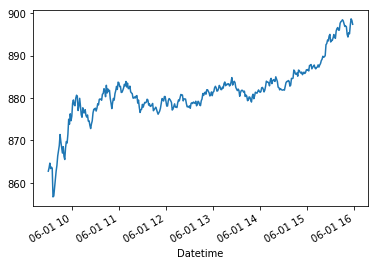

In [3]:
tsla_test = yf.download('TSLA', 
                      start='2020-06-01', 
                      end='2020-06-02',
                     interval = '1m')
#tsla_test['Close'].plot()
print(tsla_test.shape)
print(tsla_test.index[tsla_test.shape[0]-1])
tsla_mod = tsla_test.drop(tsla_test.index[tsla_test.shape[0]-1])
print(tsla_mod.shape)
#help(tsla_test)
#help(yf.ticker)
print(tsla_mod)
tsla_mod['Close'].plot()


In [4]:
from tf_agents.environments import py_environment

# ticker  = yf.Ticker('TSLA')
# tsla_df = ticker.history(period="max")
#'data = tsla_mod['Close']

class StockAttackEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
    self._episode_ended = False
    self.episodeTimeStepNumber = 0
    self.initCapital           = 1000
    self._state                 = self.initCapital
    self.ownedStock            = 0
    self.data = tsla_mod['Close']
    self.cost = 1

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = self.initCapital #start with value of 100
    self._episode_ended = False
    self.episodeTimeStepNumber = 0
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _step(self, action):
    
    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    #define observation = current stock price, ATTENTION obseration could be known values?
    self._observation_spec = self.data[self.episodeTimeStepNumber]
    #self._observation_spec = self.episodeTimeStepNumber
    
    # Make sure episodes don't go on forever.
    price_buy  = self.data[self.episodeTimeStepNumber]+self.cost
    price_sell = self.data[self.episodeTimeStepNumber]-self.cost
    if action == 1:
    #start out with buying/selling always the max amount of stocks
        howManyStocksCanIAfford = (self._state-self._state%price_buy)/price_buy
        if howManyStocksCanIAfford > 0:
            self._state = self._state - (price_buy - self.cost) *howManyStocksCanIAfford
            self.ownedStock = self.ownedStock + howManyStocksCanIAfford
            
            
    elif action == 0:
      #do nothing
        pass
    elif action == 2:
        self._state     = self._state + price_sell * self.ownedStock
        self.ownedStock = 0
    else:
      raise ValueError('`action` should be 0 or 1.')

    reward = self._state + price_sell * self.ownedStock - self.initCapital
    if self.data.shape[0]-1>self.episodeTimeStepNumber:
        self.episodeTimeStepNumber +=1
        #import pdb; pdb.set_trace()
        return ts.transition(np.array([self._state], dtype=np.int32), reward, discount=0.0)
    else:
      self._episode_ended = True
      return ts.termination(np.array([self._state], dtype=np.int32), reward)

    #print(action)
    
    

In [5]:
# this does not work, no clue why
environment = StockAttackEnv()
utils.validate_py_environment(environment, episodes=5)


In [6]:
#not sure if reward has to cumulative, if yes make reward the difference to the init state
#e.g. init state = 1000, current state = 1100  reward = +100

buy_action = np.array(1, dtype=np.int32)
sell_action = np.array(2, dtype=np.int32)
wait_action = np.array(0, dtype=np.int32)

environment = StockAttackEnv()
time_step = environment.reset()
#print(time_step)
cumulative_reward = time_step.reward
current_observation = environment.observation_spec()
print(cumulative_reward, current_observation)

time_step = environment.step(buy_action)
#print(time_step)
cumulative_reward += time_step.reward
current_observation = environment.observation_spec()
print(cumulative_reward, current_observation)

time_step = environment.step(wait_action)
cumulative_reward += time_step.reward
current_observation = environment.observation_spec()
print(cumulative_reward, current_observation)

time_step = environment.step(sell_action)
#print(time_step)
cumulative_reward += time_step.reward
current_observation = environment.observation_spec()
print(cumulative_reward, current_observation)

print('Final Reward = ', cumulative_reward)


0.0 BoundedArraySpec(shape=(1,), dtype=dtype('int32'), name='observation', minimum=0, maximum=2147483647)
-1.0 862.75
-1.2199707 863.530029296875
-0.32495117 864.64501953125
Final Reward =  -0.32495117


In [7]:
#train on simple environment

#parameters
num_iterations = 20 # @param {type:"integer"}

initial_collect_steps = 20  # @param {type:"integer"} 
collect_steps_per_iteration = 100  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 16  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 2  # @param {type:"integer"}

num_eval_episodes = 1  # @param {type:"integer"}
eval_interval = 1  # @param {type:"integer"}

PyEnv = StockAttackEnv()
env = tf_py_environment.TFPyEnvironment(PyEnv)
env.reset()
action_spec = PyEnv.action_spec()
#print(action_spec.shape)

fc_layer_params = (1000,)

q_net = q_network.QNetwork(
    env.observation_spec(),
    env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

step_counter = tf.compat.v2.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=step_counter)

agent.initialize()

print(agent.collect_data_spec)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name='observation', minimum=array(0), maximum=array(2147483647)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(2)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [8]:
def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1



    
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
returns = [avg_return]
print(avg_return)

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      env, agent.collect_policy, collect_steps_per_iteration)

  dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
  iterator = iter(dataset)
  iterator.next()
  # Use data from the buffer and update the agent's network.
  #experience = replay_buffer.gather_all()
  experience, unused_info = next(iterator)
  #import pdb; pdb.set_trace()
  train_loss = agent.train(experience).loss
  replay_buffer.clear()

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)


0.0
step = 1: Average Return = 0.0
step = 2: loss = 255568.46875
step = 2: Average Return = 0.0
step = 3: Average Return = 6871.68798828125
step = 4: loss = 92810512.0
step = 4: Average Return = 4459129.5
step = 5: Average Return = 3089205.25
step = 6: loss = 40147624.0
step = 6: Average Return = 691834.6875
step = 7: Average Return = 2746723.5
step = 8: loss = 119873352.0
step = 8: Average Return = 1034316.0
step = 9: Average Return = 6171539.0
step = 10: loss = 109054064.0
step = 10: Average Return = 1719278.875
step = 11: Average Return = 6171539.0
step = 12: loss = 137156496.0
step = 12: Average Return = 4116648.75
step = 13: Average Return = 6164667.0
step = 14: loss = 3898281.25
step = 14: Average Return = 6871.68798828125
step = 15: Average Return = 6514019.0
step = 16: loss = 149149728.0
step = 16: Average Return = 6171539.0
step = 17: Average Return = 4116648.75
step = 18: loss = 83675920.0
step = 18: Average Return = 3774167.75
step = 19: Average Return = 5144095.5
step = 20:

Text(0.5, 0, 'Step')

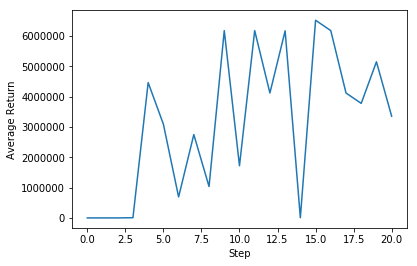

In [9]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
#plt.ylim(top=250)